# 0. Trabalho de Conclusão de Curso

TITULO: Previsão de Mercado Financeiro com Abordagens de Machine Learning e Séries Temporais

ALUNO: Leonardo Alves Santana

# 1. Importação de Bibliotecas e Dados

In [108]:
#importando a biblioteca do YahooFinance para baixar cotações
import yfinance as yF 

# Imports para manipulação de dados
import numpy as np
import pandas as pd

# Imports para visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Importando os pacotes para o modelo preditivo
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV, KFold

# Imports para series temporais
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

#formatando valores com duas casas decimais
pd.options.display.float_format = '{:.4f}'.format
import warnings
warnings.filterwarnings("ignore")

In [109]:
# Carrega o dataset
Cotacoes = yF.Ticker("PETR4.SA")

# Define o período fixo
df = Cotacoes.history(start="2018-08-01", end="2025-08-31")

# Retirar o indice do campo data
df.reset_index(inplace=True)


# 2. Funções

In [124]:
def plot_heatmap(df, cols, figsize=(12,8)): 
    '''Função para plotar a matriz de confusão das variaveis'''
    plt.figure(figsize=figsize)               
    corr = df[cols].corr()
    sns.heatmap(corr, annot=True, cmap="Blues", fmt=".3f", linewidths=0.5)
    #plt.title("Matriz de Correlação", fontsize=12)
    plt.show()



def avaliar_modelos(X_treino, Y_treino, X_teste, Y_teste):
    '''Função para testar diferentes modelos'''
    modelos = {
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(alpha=1.0),
        "Lasso": Lasso(alpha=0.001, max_iter=5000),
        "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
        "MLPRegressor": MLPRegressor(max_iter=2000, random_state=42)
    }
    
    resultados = []
    
    for nome, modelo in modelos.items():
        modelo.fit(X_treino, Y_treino)
        pred = modelo.predict(X_teste)
        
        r2 = r2_score(Y_teste, pred)
        mae = mean_absolute_error(Y_teste, pred)
        rmse = np.sqrt(mean_squared_error(Y_teste, pred))
        
        resultados.append({
            "Modelo": nome,
            "R²": round(r2, 4),
            "MAE": round(mae, 2),
            "RMSE": round(rmse, 2)
        })
    
    return pd.DataFrame(resultados).sort_values(by="R²", ascending=False)


def check_stationarity(timeseries, title):
    """Realiza o teste ADF e plota a série temporal."""
    print(f"\n===== Teste de Estacionaridade ADF: {title} =====")
    result = adfuller(timeseries, autolag='AIC')

    print(f"Estatística ADF: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Valores Críticos:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.4f}")

    if result[1] <= 0.05:
        print("\nConclusão: A série é ESTACIONÁRIA. (p-value <= 0.05)")

        # Plota a série temporal
        timeseries.plot(figsize=(12, 5), title=title)
        plt.grid(True)
        plt.show()

    else:
        print("\nConclusão: A série NÃO é ESTACIONÁRIA. (p-value > 0.05)")
    
    


# 3. Tratamentos

In [111]:
df1 = df.copy()

In [112]:
# Excluir colunas que não serão utilizadas
df1.drop('Dividends', axis=1, inplace=True)
df1.drop('Stock Splits', axis=1, inplace=True)

# Renomear colunas
df1.columns = ['Data','Abertura','Maximo','Minimo','Fechamento','Volume']

# Garantir tipos corretos
df1[['Fechamento','Abertura','Maximo','Minimo','Volume']] = df1[['Fechamento','Abertura','Maximo','Minimo','Volume']].astype(float)

# Ordenar por data (por precaução)
df1.sort_values('Data', inplace=True)

df1.head()


,Data,Abertura,Maximo,Minimo,Fechamento,Volume
0,2018-08-01 00:00:00-03:00,5.3949,5.5106,5.3811,5.5106,39141700.0000
1,2018-08-02 00:00:00-03:00,5.5051,5.7226,5.4940,5.6207,69008900.0000
2,2018-08-03 00:00:00-03:00,5.8934,5.9347,5.8080,5.8135,86908000.0000
3,2018-08-06 00:00:00-03:00,5.8245,5.9126,5.7777,5.7942,44528300.0000
4,2018-08-07 00:00:00-03:00,5.8741,5.9099,5.6648,5.7033,69136700.0000


In [113]:
# Volume de dados
df1.shape

(1759, 6)

In [114]:
# Tipos de Dados
df1.dtypes

Data          datetime64[ns, America/Sao_Paulo]
Abertura                                float64
Maximo                                  float64
Minimo                                  float64
Fechamento                              float64
Volume                                  float64
dtype: object

In [115]:
# Sumário estatístico
df1.describe()

,Abertura,Maximo,Minimo,Fechamento,Volume
count,1759.0000,1759.0000,1759.0000,1759.0000,1759.0000
mean,15.8585,16.0577,15.6560,15.8563,61957141.2166
std,9.9838,10.0666,9.9038,9.9842,35877923.3345
min,3.2794,3.6082,3.2142,3.3445,9356900.0000
25%,7.6881,7.7817,7.5948,7.6966,37733750.0000
50%,11.8106,11.9913,11.6107,11.7945,54789300.0000
75%,26.4673,26.7686,26.2265,26.5817,76208300.0000
max,35.6906,35.8110,35.4868,35.6628,490230400.0000


In [116]:
# Verifica se tem linhas nulas
df1.isnull().sum()

Data          0
Abertura      0
Maximo        0
Minimo        0
Fechamento    0
Volume        0
dtype: int64

# 4. Engenharia de features e EDA

## 4.1 Criando novas variaveis

In [117]:
# Retorno diário
df1['Retorno'] = df1['Fechamento'].pct_change()


# # Médias móveis com 5 Dias, 14 Dias e 21 Dias
df1['mm5d'] = df1['Fechamento'].rolling(5).mean()
df1['mm14d'] = df1['Fechamento'].rolling(14).mean()
df1['mm21d'] = df1['Fechamento'].rolling(21).mean()


# Volatilidade (desvio padrão dos últimos 14 dias)
df1['volatilidade14'] = df1['Retorno'].rolling(14).std()

# Momentum (diferença entre preço atual e preço de N dias atrás)
df1['momentum5'] = df1['Fechamento'] - df1['Fechamento'].shift(5)
df1['momentum14'] = df1['Fechamento'] - df1['Fechamento'].shift(14)

# RSI (Relative Strength Index) - simplificado
delta = df1['Fechamento'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df1['RSI14'] = 100 - (100 / (1 + rs))

# MACD (Moving Average Convergence Divergence)
ema12 = df1['Fechamento'].ewm(span=12, adjust=False).mean()
ema26 = df1['Fechamento'].ewm(span=26, adjust=False).mean()
df1['MACD'] = ema12 - ema26
df1['MACD_signal'] = df1['MACD'].ewm(span=9, adjust=False).mean()

# Remover primeiras linhas com NaN gerados pelas médias móveis e indicadores
df1 = df1.dropna().reset_index(drop=True)


In [118]:
df1.head()

,Data,Abertura,Maximo,Minimo,Fechamento,Volume,Retorno,mm5d,mm14d,mm21d,volatilidade14,momentum5,momentum14,RSI14,MACD,MACD_signal
0,2018-08-29 00:00:00-03:00,5.1075,5.3311,5.0937,5.3283,71434300.0000,0.0518,5.1135,5.1866,5.3430,0.0298,0.2623,-0.2731,42.4680,-0.1107,-0.1073
1,2018-08-30 00:00:00-03:00,5.2869,5.3946,5.1572,5.1903,63981900.0000,-0.0259,5.1605,5.1719,5.3277,0.0290,0.2347,-0.2046,44.1356,-0.1024,-0.1063
2,2018-08-31 00:00:00-03:00,5.2317,5.3642,5.2207,5.3173,75767400.0000,0.0245,5.2135,5.1576,5.3133,0.0291,0.2650,-0.2015,44.2338,-0.0846,-0.1020
3,2018-09-03 00:00:00-03:00,5.2427,5.2814,5.1792,5.2455,25401600.0000,-0.0135,5.2295,5.1382,5.2862,0.0292,0.0801,-0.2706,42.5532,-0.0754,-0.0967
4,2018-09-04 00:00:00-03:00,5.2814,5.2980,5.1406,5.1489,39759800.0000,-0.0184,5.2461,5.1303,5.2555,0.0269,0.0828,-0.1104,46.6667,-0.0750,-0.0923


## 4.2 EDA (Exploratory Data Analysis)

In [119]:
df1.describe()

,Abertura,Maximo,Minimo,Fechamento,Volume,Retorno,mm5d,mm14d,mm21d,volatilidade14,momentum5,momentum14,RSI14,MACD,MACD_signal
count,1739.0000,1739.0000,1739.0000,1739.0000,1739.0000,1739.0000,1739.0000,1739.0000,1739.0000,1739.0000,1739.0000,1739.0000,1739.0000,1739.0000,1739.0000
mean,15.9790,16.1798,15.7754,15.9772,62021049.7412,0.0014,15.9475,15.8827,15.8330,0.0222,0.0739,0.2005,54.3278,0.1014,0.1017
std,9.9772,10.0594,9.8974,9.9772,36052622.2704,0.0260,9.9660,9.9437,9.9257,0.0137,0.8254,1.3936,16.9425,0.3803,0.3503
min,3.2794,3.6082,3.2142,3.3445,9356900.0000,-0.2970,3.5549,3.8875,4.1487,0.0064,-4.9094,-6.1785,9.6590,-1.3077,-1.1501
25%,7.7631,7.8505,7.6445,7.7543,37490000.0000,-0.0102,7.7358,7.7468,7.6971,0.0150,-0.2647,-0.3703,42.4943,-0.0810,-0.0692
50%,11.8819,12.1116,11.6888,11.8929,54708900.0000,0.0010,11.9701,11.8759,11.8545,0.0199,0.0889,0.2209,55.1715,0.1044,0.1014
75%,26.6422,27.0353,26.3633,26.7010,76344100.0000,0.0137,26.6543,26.3850,26.2104,0.0257,0.4631,0.8748,66.1211,0.2861,0.2806
max,35.6906,35.8110,35.4868,35.6628,490230400.0000,0.2222,35.5349,34.7821,34.6668,0.1450,2.9726,5.1398,95.0464,1.3676,1.2068


#### Histograma do fechamento

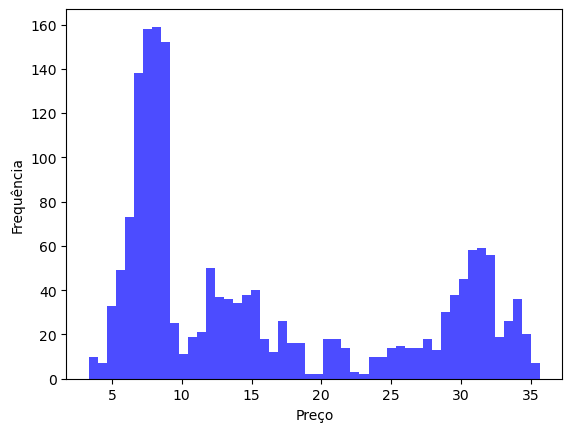

In [120]:
plt.hist(df1['Fechamento'], bins=50, color='blue', alpha=0.7)
#plt.title("Distribuição do Preço de Fechamento")
plt.xlabel("Preço")
plt.ylabel("Frequência")
plt.show()

#### Série temporal do preço de fechamento e média móvel

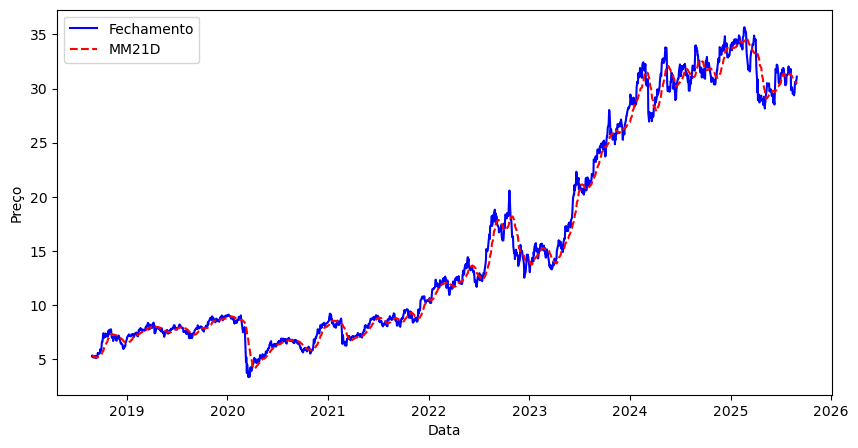

In [121]:
plt.figure(figsize=(10,5))
plt.plot(df1['Data'], df1['Fechamento'], label='Fechamento', color='blue')
plt.plot(df1['Data'], df1['mm21d'], label='MM21D', color='red', linestyle='--')
#plt.title("Preço de Fechamento e Média Móvel 21D")
plt.xlabel("Data")
plt.ylabel("Preço")
plt.legend()
plt.show()


#### Boxplot dos retornos


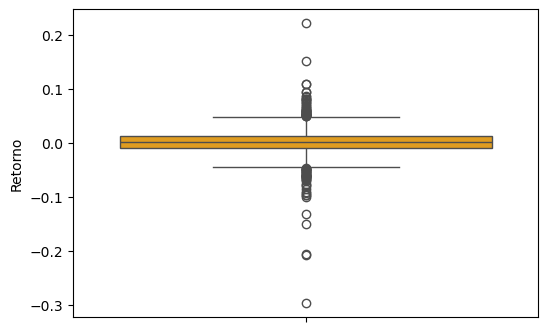

In [122]:
plt.figure(figsize=(6,4))
sns.boxplot(y=df1['Retorno'].dropna(), color='orange')
#plt.title("Boxplot dos Retornos Diários")
plt.ylabel("Retorno")
plt.show()


#### Matriz de correlação

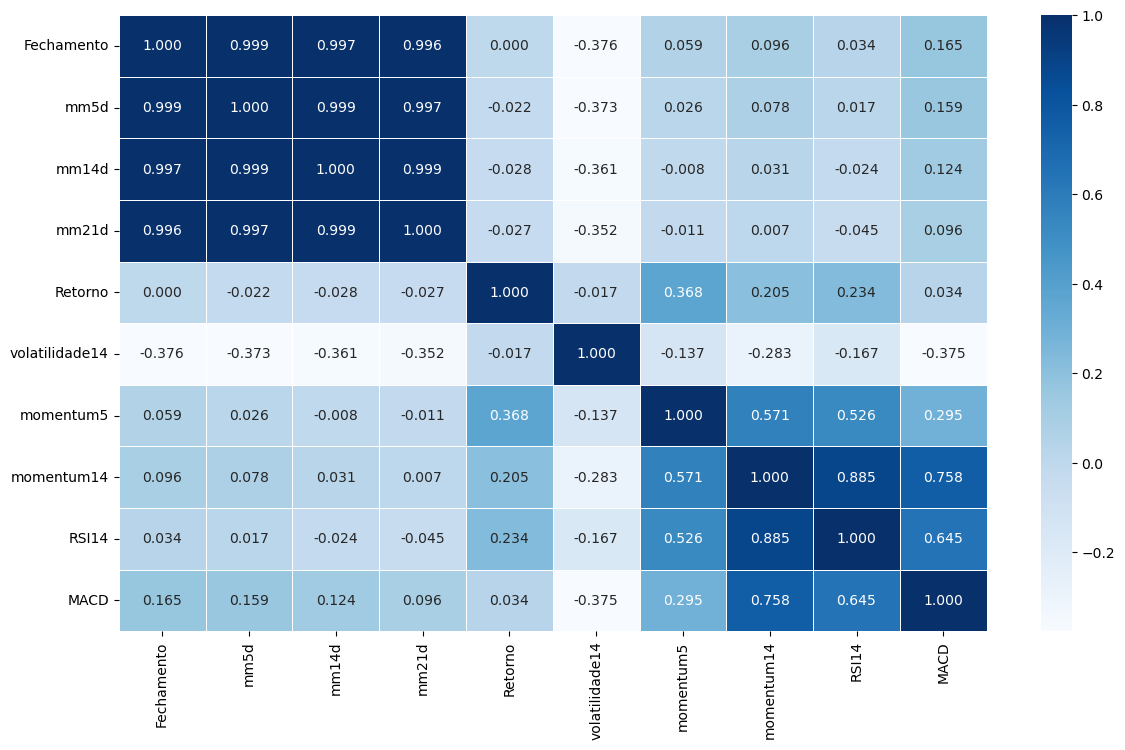

In [125]:
cols_corr = ['Fechamento','mm5d','mm14d','mm21d','Retorno','volatilidade14','momentum5','momentum14','RSI14','MACD']
plot_heatmap(df1, cols_corr, figsize=(14,8))


## 4.3 Escolhendo as melhores features

In [ ]:
## Escolhendo as melhores features com Kbest

# Separando variaveis PREDITORAS (features) e variavel ALVO (labels)
features = df1.drop(['Data', 'Fechamento'], axis=1)
labels = df1['Fechamento']

# Crie uma lista com os nomes das colunas de features
features_list = features.columns.values

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_

# zip para parear a lista de features com os scores
raw_pairs = zip(features_list, k_best_features_scores)

ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))
k_best_features_final = dict(ordered_pairs[:15])

print("\nMelhores features:")
print(k_best_features_final)


Melhores features:
{'Maximo': 5823.28130479837, 'Minimo': 3681.343714524982, 'Abertura': 1905.5911218363574, 'mm5d': 791.1165817137825, 'mm14d': 357.8953248805746, 'mm21d': 319.82510044252155, 'volatilidade14': 4.615260136514751, 'momentum14': 3.332858179606701, 'MACD': 3.2787199418898614, 'MACD_signal': 2.627732707735351, 'RSI14': 2.2596302238884887, 'Retorno': 1.3051762198321675, 'momentum5': 1.2490749579817577, 'Volume': 1.020827125023969}


1. Fortes (altíssimo score)

    * Maximo, Minimo, Abertura → altamente correlacionados com Fechamento (faz sentido, todos vêm do mesmo candle).

    * mm5d, mm14d, mm21d → médias móveis, capturam tendência → muito úteis.

2. Moderados (médio score)

    * volatilidade14, momentum14, MACD, MACD_signal, RSI14 → variáveis derivadas, podem trazer valor em modelos mais sofisticados.

3. Fracos (baixo score)

    * Retorno, momentum5, Volume → pouca explicação estatística sozinhos.

In [19]:
# Separando variáveis preditoras (features) e variável alvo (labels)
features = df1.drop(['Data', 'Fechamento', 'Retorno', 'momentum5', 'Volume'], axis=1)
labels = df1['Fechamento']

print("Features finais:")
print(features.columns.tolist())

Features finais:
['Abertura', 'Maximo', 'Minimo', 'mm5d', 'mm14d', 'mm21d', 'volatilidade14', 'momentum14', 'RSI14', 'MACD', 'MACD_signal']


# 5. Regressão Linear

## 5.1 Pré processamento

In [ ]:
# Normalizando os dados
scaler = MinMaxScaler().fit(features)
preditoras_normalizadas = scaler.transform(features)


# Defina a proporção de cada conjunto
proporcao_treino = 0.70
proporcao_validacao = 0.15
proporcao_teste = 0.15

# Calcule os índices de divisão
# O arredondamento garante que você tenha números inteiros
qtd_linhas = len(df1)
indice_treino = int(qtd_linhas * proporcao_treino)
indice_validacao = int(qtd_linhas * (proporcao_treino + proporcao_validacao))
indice_teste = qtd_linhas


# Separando dados para treino, teste e validação
X_treino = preditoras_normalizadas[0:indice_treino]
X_validacao = preditoras_normalizadas[indice_treino:indice_validacao]
X_teste = preditoras_normalizadas[indice_validacao:indice_teste]

Y_treino = labels.iloc[0:indice_treino]
Y_validacao = labels.iloc[indice_treino:indice_validacao]
Y_teste = labels.iloc[indice_validacao:indice_teste]

print(f"Total: {qtd_linhas} | Treino: {len(X_treino)} | Validação: {len(X_validacao)} | Teste: {len(X_teste)}")


Total: 1739 | Treino: 1217 | Validação: 261 | Teste: 261


## 5.2 Escolha do melhor modelo

In [23]:
tabela_resultados = avaliar_modelos(X_treino, Y_treino, X_validacao, Y_validacao)
display(tabela_resultados)

,Modelo,R²,MAE,RMSE
0,LinearRegression,0.9978,0.1200,0.1500
2,Lasso,0.9954,0.1700,0.2200
1,Ridge,0.9897,0.2600,0.3200
5,MLPRegressor,0.9464,0.5800,0.7400
3,RandomForest,-4.0411,6.4600,7.1800
4,GradientBoosting,-4.1085,6.5100,7.2300


O modelo de Regressão Linear simples apresentou o melhor desempenho, com R² = 0,9978 e os menores erros (MAE = 0,12 e RMSE = 0,15). Isso indica que a relação entre as variáveis é fortemente linear, e modelos mais complexos não trouxeram ganhos adicionais. Assim, optamos por utilizar a Regressão Linear como modelo final.

## 5.3 Escolha dos melhores hiperparâmetros 

In [167]:
# Definir os hiperparâmetros que deseja testar
param_grid = {
    "fit_intercept": [True, False],
    "positive": [True, False]  # força coeficientes positivos (pode ou não ser útil)
}

# validação cruzada k-fold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=param_grid,
    scoring="r2",   
    cv=cv,
    n_jobs=-1
)

# Ajusta apenas nos dados de treino
grid_search.fit(X_treino, Y_treino)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor score médio (validação cruzada):", grid_search.best_score_)


Melhores parâmetros: {'fit_intercept': True, 'positive': False}
Melhor score médio (validação cruzada): 0.9995830015666579


In [ ]:
# Melhor modelo do GridSearch
best_model = grid_search.best_estimator_

# Avaliar no conjunto de validação
y_pred_val = best_model.predict(X_validacao)

r2 = r2_score(Y_validacao, y_pred_val)
mae = mean_absolute_error(Y_validacao, y_pred_val)
rmse = np.sqrt(mean_squared_error(Y_validacao, y_pred_val))

print("Avaliação no conjunto de validação externo:")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


Avaliação no conjunto de validação externo:
R²: 0.9978
MAE: 0.1159
RMSE: 0.1491


O modelo de Regressão Linear, ajustado com os melhores hiperparâmetros encontrados via validação cruzada, apresentou um desempenho um pouco superior que anteriormente.

## 5.4 Avaliação Final

In [170]:
# Combinando os dados de treino e validação
X_treino_val = np.concatenate((X_treino, X_validacao))
Y_treino_val = np.concatenate((Y_treino, Y_validacao))

# Treinar o modelo final nos dados combinados
best_model.fit(X_treino_val, Y_treino_val)

# Fazer a predição no conjunto de teste
y_pred_test = best_model.predict(X_teste)


# Calcular métricas finais
r2 = r2_score(Y_teste, y_pred_test)
mae = mean_absolute_error(Y_teste, y_pred_test)
rmse = np.sqrt(mean_squared_error(Y_teste, y_pred_test))

print("Métricas no conjunto de teste final:")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

print("\nComentário final:")
print(f"O modelo de Regressão Linear final, treinado com todos os dados de treino e validação, "
      f"apresentou um desempenho muito bom no conjunto de teste, com R² = {r2:.4f}, "
      f"MAE = {mae:.4f} e RMSE = {rmse:.4f}. Isso indica que o modelo generaliza bem para "
      "novos dados, capturando com precisão a evolução do preço de fechamento das ações.")


Métricas no conjunto de teste final:
R²: 0.9942
MAE: 0.1072
RMSE: 0.1377

Comentário final:
O modelo de Regressão Linear final, treinado com todos os dados de treino e validação, apresentou um desempenho muito bom no conjunto de teste, com R² = 0.9942, MAE = 0.1072 e RMSE = 0.1377. Isso indica que o modelo generaliza bem para novos dados, capturando com precisão a evolução do preço de fechamento das ações.


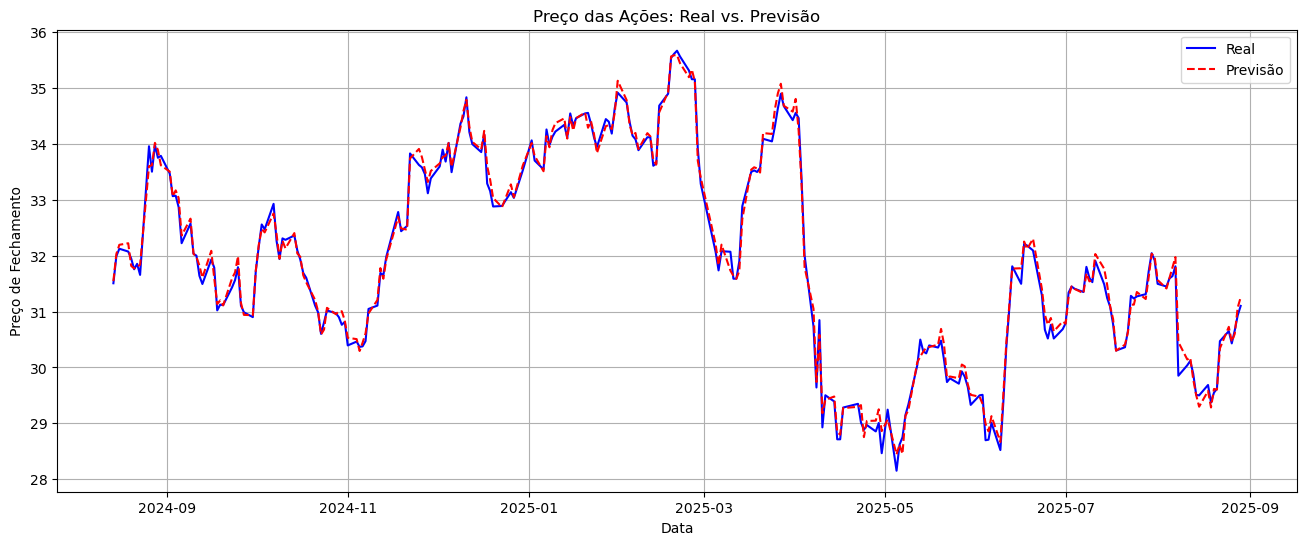

In [ ]:
# Criar DataFrame com resultados
df_resultados = pd.DataFrame({
    'Real': Y_teste.values,        
    'Previsão': y_pred_test
}, index=df1['Data'].iloc[indice_validacao:indice_teste])  # usar datas reais

# Plotagem
plt.figure(figsize=(16,6))
plt.plot(df_resultados.index, df_resultados['Real'], label='Real', color='blue')
plt.plot(df_resultados.index, df_resultados['Previsão'], label='Previsão', color='red', linestyle='--')
plt.title('Preço das Ações: Real vs. Previsão')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

# 6. Arima Model

In [22]:
df2 = df1.copy()

In [23]:
# Garantir ordenação por data
ts = df2[['Data', 'Fechamento']].sort_values('Data')
ts.set_index('Data', inplace=True)

# Separar treino e teste (70/30 ou mesmo divisão que usou antes)
qtd_linhas = len(ts)
indice_treino = int(qtd_linhas * 0.7)

train_ts = ts.iloc[:indice_treino]
test_ts = ts.iloc[indice_treino:]


#### Decomposição da série

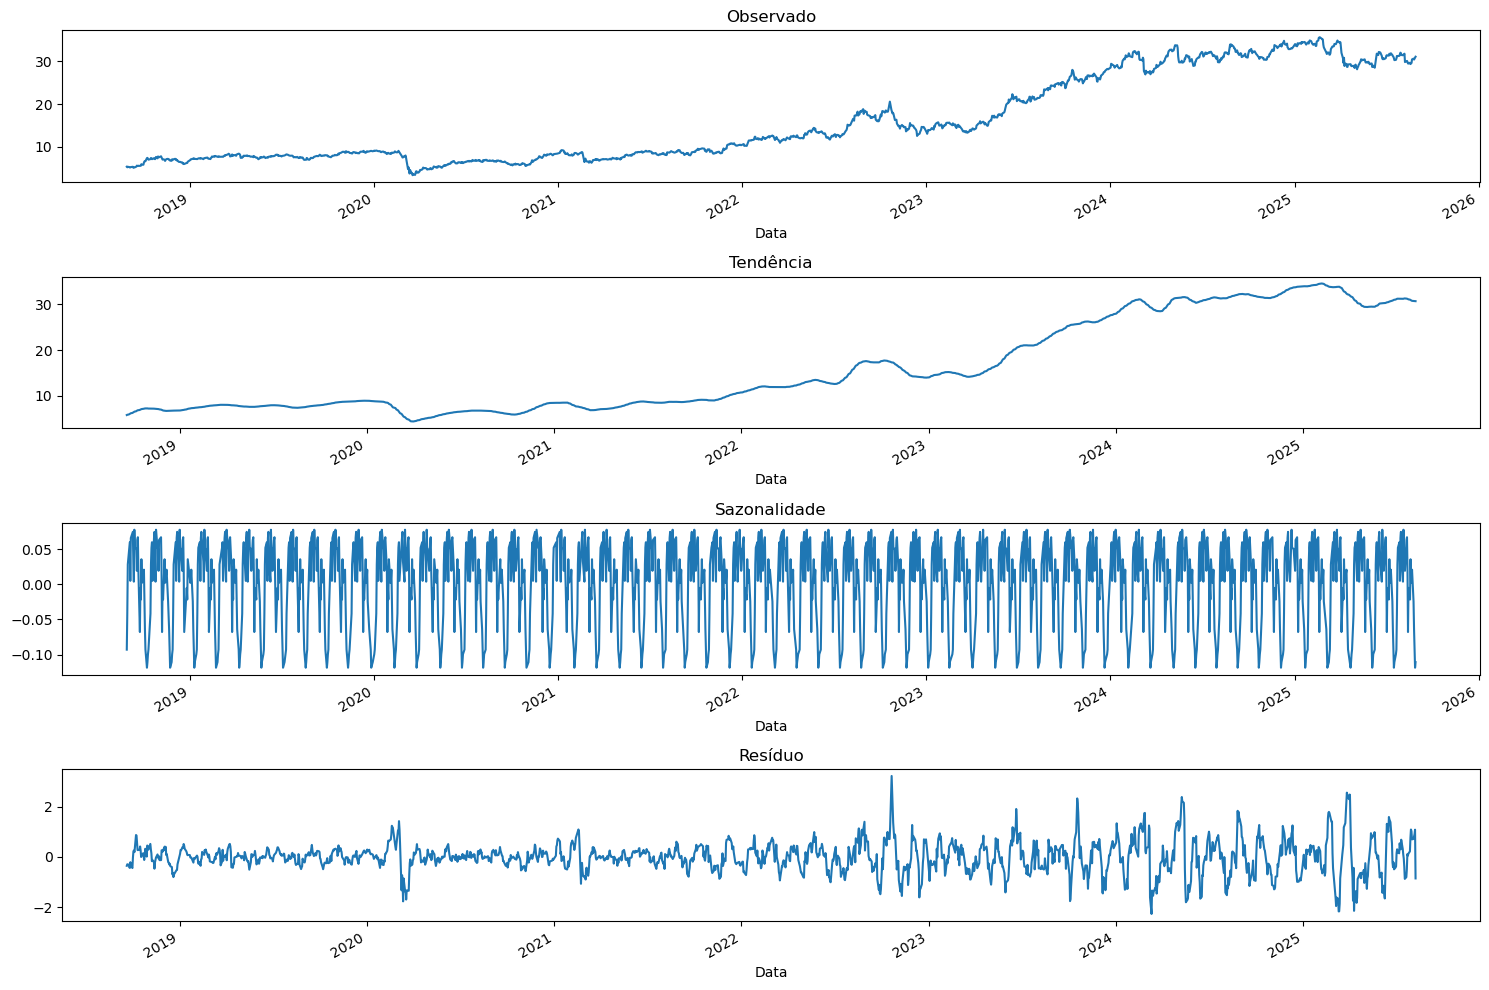

In [29]:
# Decomposição aditiva da série (30 pois os dados sao por dia, dai na media o mês tem 30 dias)
decomposicao = seasonal_decompose(ts['Fechamento'], model='additive', period=30)

# Crie a figura e os subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))

# Plote cada componente em seu próprio subplot
decomposicao.observed.plot(ax=ax1, title='Observado')
decomposicao.trend.plot(ax=ax2, title='Tendência')
decomposicao.seasonal.plot(ax=ax3, title='Sazonalidade')
decomposicao.resid.plot(ax=ax4, title='Resíduo')

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba o gráfico
plt.show()

#### Análise de Estacionaridade

In [ ]:
check_stationarity(ts['Fechamento'], 'Série de Fechamento Original')


===== Teste de Estacionaridade ADF: Série de Fechamento Original =====
Estatística ADF: -0.1794
p-value: 0.9409
Valores Críticos:
	1%: -3.4342
	5%: -2.8632
	10%: -2.5677

Conclusão: A série NÃO é ESTACIONÁRIA. (p-value > 0.05)



===== Teste de Estacionaridade ADF: Série de Fechamento Diferenciada (d=1) =====
Estatística ADF: -10.6809
p-value: 0.0000
Valores Críticos:
	1%: -3.4342
	5%: -2.8632
	10%: -2.5677

Conclusão: A série é ESTACIONÁRIA. (p-value <= 0.05)


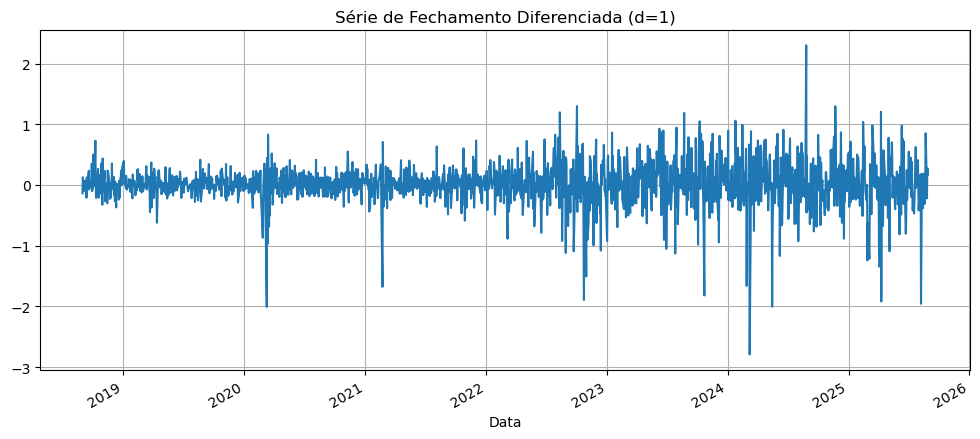

In [34]:
# Realiza a diferenciação e remove o valor NaN
ts_diff = ts['Fechamento'].diff().dropna()

check_stationarity(ts_diff, 'Série de Fechamento Diferenciada (d=1)')


O grafico mostra a série diferenciada, que parecerá muito mais aleatória e centrada em zero, provando visualmente que ela se tornou estacionária.

#### Auto Arima

In [71]:
print("\n===== Encontrando o Melhor Modelo ARIMA =====")
auto_model = auto_arima(
    train_ts['Fechamento'],      # Dados de treino para a busca
    start_p=1, start_q=1,        # Parâmetros iniciais para a busca
    max_p=3, max_q=3,            # Limite superior para a busca de p e q
    m=12,                        # m=12 para sazonalidade mensal 
    stationary=False,            # Indica que a série não é estacionária
    seasonal=True,               # Ativa a busca por sazonalidade
    start_P=0,                   # Parâmetro inicial para a parte sazonal (P)
    d=1,                         # Fixa a diferenciação em 1, conforme sua análise
    trace=True,                  # Exibe o progresso da busca
    error_action='ignore',       # Ignora erros durante a busca
    stepwise=True,               # Usa a busca otimizada para ser mais rápido
    suppress_warnings=True
)

# Resumo do modelo encontrado
print(auto_model.summary())
print(f"\nMelhor modelo encontrado: {auto_model.get_params()['order']}")


===== Encontrando o Melhor Modelo ARIMA =====
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=339.025, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=334.496, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=337.041, Time=0.41 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=337.051, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=334.987, Time=0.05 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=335.192, Time=0.17 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=335.209, Time=0.33 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=336.426, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=336.302, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=336.295, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=338.266, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 3.146 seconds
                               SARIMAX Results                                
Dep. Variable:             

In [55]:
# Treinamento e Previsão

p, d, q = auto_model.get_params()['order']


# O modelo ARIMA será treinado nos dados de treino.
model = ARIMA(train_ts, order=(p, d, q))
model_fit = model.fit()

predictions = model_fit.predict(start=len(train_ts), end=len(ts)-1)
predictions

# predictions = []
# for i in range(len(test_ts)):
#     forecast_step = model_fit.forecast(steps=1)
#     predictions.append(forecast_step.iloc[0])


1217   20.5935
1218   20.5935
1219   20.5935
1220   20.5935
1221   20.5935
         ...  
1734   20.5935
1735   20.5935
1736   20.5935
1737   20.5935
1738   20.5935
Name: predicted_mean, Length: 522, dtype: float64

In [64]:
predictions

1217   20.5935
1218   20.5935
1219   20.5935
1220   20.5935
1221   20.5935
         ...  
1734   20.5935
1735   20.5935
1736   20.5935
1737   20.5935
1738   20.5935
Name: predicted_mean, Length: 522, dtype: float64

In [60]:
# The 'predictions' variable is just a NumPy array without a date index.
# We explicitly create a Pandas Series with the index from your test data.
predictions_array = np.array(predictions)

# Now, create the DataFrame with the aligned Series.
results = pd.DataFrame({
    'Real': test_ts['Fechamento'],
    'Predito': predictions_array
})

results.head()

,Real,Predito
Data,,
2023-07-28 00:00:00-03:00,20.8528,20.5935
2023-07-31 00:00:00-03:00,21.7987,20.5935
2023-08-01 00:00:00-03:00,21.4413,20.5935
2023-08-02 00:00:00-03:00,21.3923,20.5935
2023-08-03 00:00:00-03:00,21.6656,20.5935


In [65]:
# Calcular R² e outras métricas
r2 = r2_score(results['Real'], results['Predito'])
mae = mean_absolute_error(results['Real'], results['Predito'])

print("\n===== Performance Final no Conjunto de Teste =====")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")
print(f"MAE (Erro Absoluto Médio): {mae:.4f}")



===== Performance Final no Conjunto de Teste =====
R² (Coeficiente de Determinação): -8.8004
MAE (Erro Absoluto Médio): 9.4956


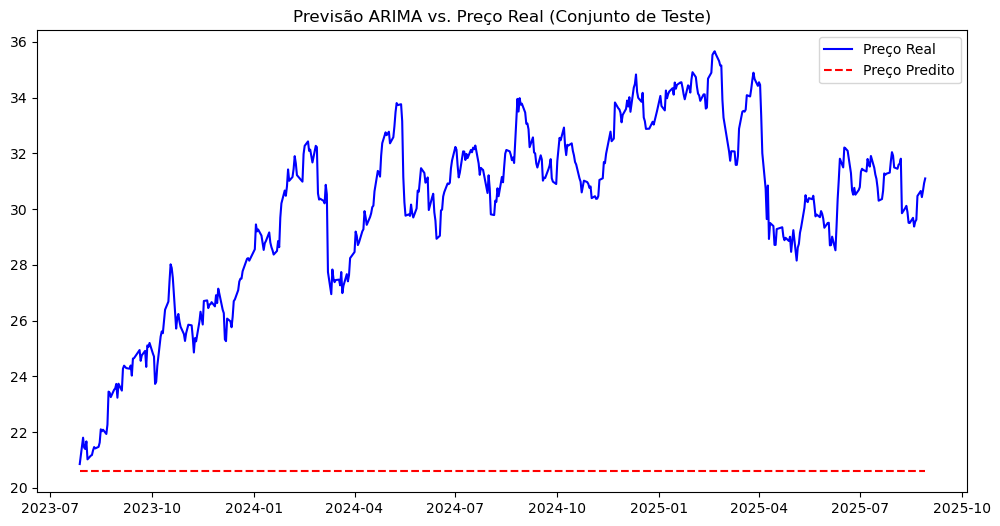

In [72]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(results['Real'], label='Preço Real', color='blue')
plt.plot(results['Predito'], label='Preço Predito', color='red', linestyle='--')
plt.title('Previsão ARIMA vs. Preço Real (Conjunto de Teste)')
plt.legend()
plt.show()

O modelo ARIMA apresentou desempenho muito ruim no conjunto de teste, com R² negativo e erros elevados (MAE e RMSE altos), indicando que não conseguiu capturar a dinâmica dos preços de PETR4 apenas com a série histórica.

# 7. LSTM (Long Short-Term Memory)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from keras_tuner import HyperModel, RandomSearch

# Avaliar métricas adicionais
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

#### Preparação dos Dados

In [103]:
df_completo = df2.copy()
ts = df_completo[['Data', 'Fechamento']].set_index('Data')


# Normalizar os dados (transforma para a escala 0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ts)

# Divisão em treino, validação e teste (70/15/15)
train_size = int(len(scaled_data) * 0.70)
val_size = int(len(scaled_data) * 0.15)
test_size = len(scaled_data) - train_size - val_size

train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size + val_size]
test_data = scaled_data[train_size + val_size:]


In [104]:
def create_sequences(data, look_back=60):
    """
    Cria janelas de tempo para o modelo LSTM.
    O 'look_back' é o número de dias que o modelo olha para trás.
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

# Crie as sequências para treino e teste
look_back = 60
X_train, y_train = create_sequences(train_data, look_back)
X_val, y_val = create_sequences(val_data, look_back)
X_test, y_test = create_sequences(test_data, look_back)

# Reformate os dados para o formato que o LSTM espera: [amostras, janelas, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val   = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


#### Construção e Treinamento do Modelo LSTM
 

In [105]:
# Definir modelo parametrizável
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int("lstm_units1", min_value=32, max_value=256, step=32),
        return_sequences=True,
        input_shape=(look_back, 1)
    ))
    model.add(LSTM(
        units=hp.Int("lstm_units2", min_value=16, max_value=128, step=16),
        return_sequences=False
    ))
    model.add(Dense(1, activation="linear"))
    
    model.compile(
        optimizer="adam",
        loss="mean_squared_error"
    )
    return model



# Busca dos Hiperparâmetros com Keras Tuner
tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,  # número de combinações testadas
    executions_per_trial=1,
    directory="tuner_dir",
    project_name="lstm_stock"
)

# Rodar busca
tuner.search(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)


# Melhor modelo
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nMelhores hiperparâmetros encontrados:")
print(best_hps.values)

Reloading Tuner from tuner_dir\lstm_stock\tuner0.json

Melhores hiperparâmetros encontrados:
{'lstm_units1': 256, 'lstm_units2': 96}


#### Previsão e avaliação do Modelo 

In [ ]:
# Avaliar no conjunto de teste
test_loss = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Loss no conjunto de teste: {test_loss}")

# Fazer previsões
y_pred = best_model.predict(X_test)

# Reverter a normalização
y_pred_real = scaler.inverse_transform(y_pred)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))


r2 = r2_score(y_test_real, y_pred_real)
mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))

print("\n===== Performance do Melhor Modelo LSTM (Keras Tuner) =====")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.0878e-04
Loss no conjunto de teste: 0.00048358627827838063
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

===== Performance do Melhor Modelo LSTM (Keras Tuner) =====
R²: 0.8743
MAE: 0.5277
RMSE: 0.7107


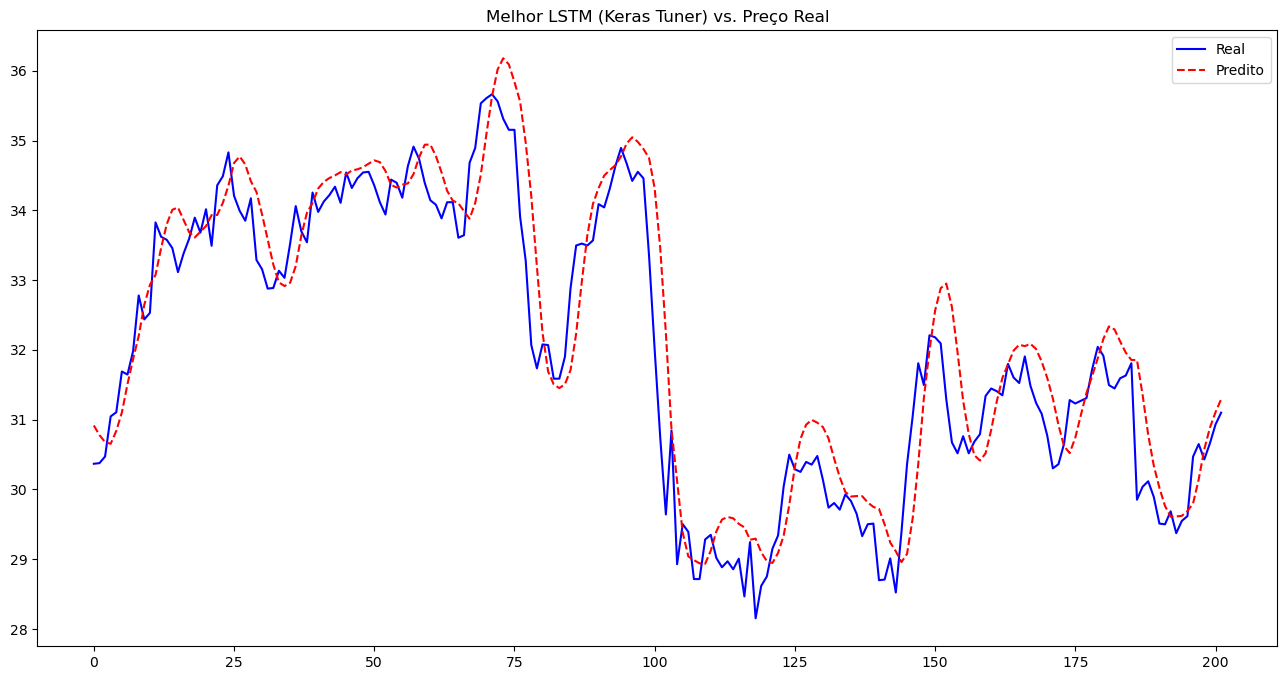

In [107]:
# Plotar resultados
plt.figure(figsize=(16,8))
plt.plot(y_test_real, label='Real', color='blue')
plt.plot(y_pred_real, label='Predito', color='red', linestyle='--')
plt.title('Melhor LSTM (Keras Tuner) vs. Preço Real')
plt.legend()
plt.show()

O LSTM otimizado supera tanto o ARIMA quanto o LSTM padrão.

# 8. Conclusão

Neste projeto, analisamos a previsão do preço das ações da PETR4 utilizando tanto modelos de regressão linear com features técnicas (médias móveis, volatilidade, momentum, etc.) quanto modelos de séries temporais, incluindo ARIMA e LSTM.

Os resultados mostraram que a regressão linear com variáveis derivadas do próprio ativo apresentou excelente desempenho, com R² de 0,9942 e erros baixos (MAE e RMSE), fornecendo previsões precisas e consistentes.

Modelos clássicos de séries temporais aplicados apenas aos preços históricos, como ARIMA, não conseguiram capturar adequadamente as variações do ativo, resultando em R² negativo e erros significativamente maiores.

O modelo LSTM, agora avaliado com uma divisão apropriada entre treino, validação e teste, obteve desempenho sólido (R² = 0,8743, MAE = 0,5277, RMSE = 0,7107). Embora ligeiramente inferior à regressão linear com features derivadas, o LSTM ainda demonstrou capacidade de capturar padrões temporais complexos da série de preços.

O estudo reforça que, para previsão de preços de ações neste contexto, a modelagem baseada em features técnicas derivadas do ativo é mais eficaz que o uso isolado da série temporal, mas técnicas avançadas de deep learning, como LSTM, podem complementar a análise e oferecer insights sobre a dinâmica temporal do mercado.